In [ ]:
# Imports
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.models import MobileNet_V2_Weights

import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from tqdm.notebook import tqdm
import tempfile
import shutil
import random
from sklearn.model_selection import KFold

mount drive if running in google colab


In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print("In Colab: {}".format(IN_COLAB))

if IN_COLAB:
    from image_utils import get_sample_image_size
    from csv_utils import split_classes, how_many, split_classes_threshold
    from file_utils import train_test_split, num_images
    from google.colab import drive
    drive.mount('/content/gdrive')

else:
    import sys
    sys.path.append("..")
    from src.utils.image_utils import get_sample_image_size
    from src.utils.csv_utils import split_classes, how_many, split_classes_threshold
    from src.utils.file_utils import train_test_split, num_images

In Colab: True
Mounted at /content/gdrive


set computation device to gpu if available


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}")

Computation device: cuda


set seed for reproducibility


In [ ]:
torch.manual_seed(0)
random.seed(0)

Set hyperparameters



In [ ]:
EPOCHS = 10
BATCH = 32
FOLDS = 5

# percent of all data to go towards testing and validation
# TRACKS_PER_CLASS = 500
PERCENT_TESTING = 0.15
PERCENT_VALIDATION = 0.15
LEARNING_RATE = 0.001

# spectrogram parameters
RESOLUTION = "low" # low or high
TRACK_DURATION = 15 # 15 or 31

# popularity thresholds
# TRACKS_PER_CLASS = 1000
HIGH_THRESHOLD = 500000
LOW_THRESHOLD = 500000

Choose Model

In [ ]:
# load the model
model_name = 'MobileNet-v2'
model = models.mobilenet_v2(weights = MobileNet_V2_Weights.IMAGENET1K_V2).to(device)

# print(model)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

#### load the train and test data


In [ ]:
# Setting paths
base_path = f"../data" if not IN_COLAB else f"/content/gdrive/MyDrive/AI-Project/data"
dir_name = f"ch_{RESOLUTION}_{TRACK_DURATION}_all"
spectrograms_path = f"{base_path}/spectrograms/{dir_name}"
csv_path = f"{base_path}/audio_features.csv"
df = pd.read_csv(csv_path)

print(f"Csv Length: {len(df)}")
print(f"Number of spectrograms: {num_images(spectrograms_path)}")

num_viral = how_many(
    csv_path, 'number_of_videos', HIGH_THRESHOLD, 'above')
num_not_viral = how_many(
    csv_path, 'number_of_videos', LOW_THRESHOLD, 'below')

print(f"Number of tracks above threshold: {num_viral}")
print(f"Number of tracks below threshold: {num_not_viral}")

Csv Length: 3932
Number of spectrograms: 3914
Number of tracks above threshold: 1416
Number of tracks below threshold: 2516


All images should be the same size but we resize them according to the first image just to be safe.


In [ ]:
image_size = get_sample_image_size(spectrograms_path)
HEIGHT, WIDTH = image_size[0], image_size[1]
print(f"height: {image_size[0]}, width: {image_size[1]}")

Number of channels in the image: 1
height: 128, width: 160


In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((HEIGHT, WIDTH)),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)


def get_datasets():

    # create temporary folder to store spectrograms
    root_dir = "../data/temp" if not IN_COLAB else './temp'
    os.makedirs(root_dir, exist_ok=True)
    temp_dir = tempfile.mkdtemp(dir=root_dir)

    # split into two classes based on popularity thresholds
    out_path = f"{temp_dir}/"
    # split_classes(
    #     csv_path, spectrograms_path, out_path, ["viral", "notviral"], TRACKS_PER_CLASS
    # )
    split_classes_threshold(csv_path, spectrograms_path, out_path, [
                            "viral", "notviral"], HIGH_THRESHOLD, LOW_THRESHOLD)

    # copy spectrograms to temporary folder split into train and test directories
    data_dir = tempfile.mkdtemp(prefix=dir_name + '_', dir=root_dir)
    print(f"Data directory: {data_dir}")
    train_dir, test_dir = train_test_split(temp_dir, data_dir, PERCENT_TESTING)
    train_dataset = ImageFolder(train_dir, transform=transform)
    test_dataset = ImageFolder(test_dir, transform=transform)

    # delete temporary folder
    shutil.rmtree(temp_dir)
    return train_dataset, test_dataset, data_dir

In [ ]:
train_dataset, test_dataset, data_dir = get_datasets()

print(f"number of training images: {len(train_dataset)}")
print(f"number of testing images: {len(test_dataset)}")

Number of files in viral: 1410
Number of files in notviral: 2504
Data directory: ./temp/ch_low_15_all_snnf8tro
Number of images per class: [1410, 2504]
Number of testing images per class: [211, 375]
Processing class: viral
Created subdirectories: ./temp/ch_low_15_all_snnf8tro/training/viral and ./temp/ch_low_15_all_snnf8tro/testing/viral
Processing class: notviral
Created subdirectories: ./temp/ch_low_15_all_snnf8tro/training/notviral and ./temp/ch_low_15_all_snnf8tro/testing/notviral
number of training images: 3328
number of testing images: 586


#### Looking at the dataset


In [ ]:
img, label = train_dataset[0]
print(img.shape, label)
print("classes : \n", train_dataset.classes)

# num images per class
print("num images per class")
print(train_dataset.targets.count(0))
print(train_dataset.targets.count(1))

torch.Size([3, 128, 160]) 0
classes : 
 ['notviral', 'viral']
num images per class
2129
1199


display the first image in the dataset


Label : notviral


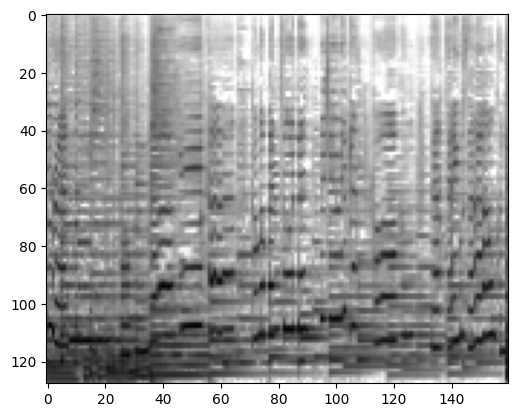

In [ ]:
def display_img(img, label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))


display_img(*train_dataset[0])

load the train and validation into batches.


In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

val_size = int(len(train_dataset) * PERCENT_VALIDATION)
train_size = len(train_dataset) - val_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

# train_dl = DataLoader(train_data, BATCH, shuffle = True, num_workers = 4, pin_memory = True)
# val_dl = DataLoader(val_data, BATCH*2, num_workers = 4, pin_memory = True)

train_dl = DataLoader(train_data, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_data, batch_size=BATCH)
test_dl = DataLoader(test_dataset, batch_size=BATCH)

Length of Train Data : 2829
Length of Validation Data : 499


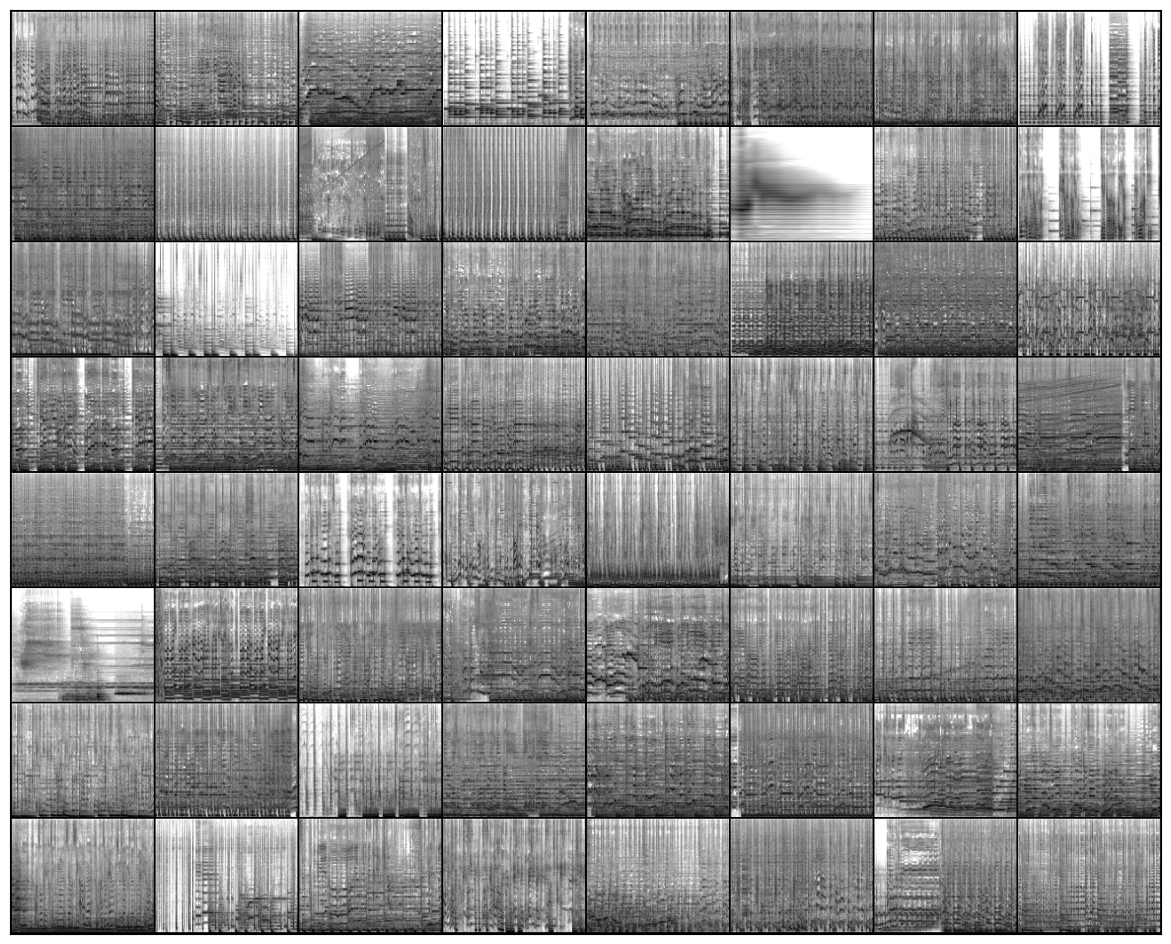

In [ ]:
from torchvision.utils import make_grid


def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


show_batch(train_dl)

Training and testing the model:


In [ ]:
# For fold results
results = {}
history = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=FOLDS, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):

  # saves losses
  fold_history = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
  }

  # Print
  print(f'FOLD {fold + 1} out of {FOLDS}')
  print('--------------------------------')

  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=10, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=10, sampler=test_subsampler)
  # Init model
  model = models.mobilenet_v2(weights = MobileNet_V2_Weights.IMAGENET1K_V2).to(device)

  # Initialize optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # Run the training loop for defined number of epochs
  for epoch in range(0, EPOCHS):

    # Print epoch
    print(f'Starting epoch {epoch+1} out of {EPOCHS}')

    # Set cumulative loss and correct prediction count value for this epoch
    cum_loss = 0.0
    cum_correct = 0
    total = 0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

      # Get inputs
      inputs, targets = data
      inputs, targets = inputs.to(device), targets.to(device)

      # Zero the gradients
      optimizer.zero_grad()

      # Perform forward pass
      outputs = model(inputs)

      # Compute loss
      loss = loss_function(outputs, targets)

      # Perform backward pass
      loss.backward()

      # Perform optimization
      optimizer.step()

      # Update statistics
      total += targets.size(0)
      cum_loss += loss.item()
      cum_correct += (outputs.argmax(1) == targets).sum().item()

    # Print statistics and save to History
    epoch_train_loss = cum_loss / len(trainloader)
    epoch_train_acc = cum_correct / total
    fold_history['train_loss'].append(epoch_train_loss)
    fold_history['train_acc'].append(epoch_train_acc)
    print(f'Epoch training loss: {epoch_train_loss:.3f}, Epoch trainig Acc: {epoch_train_acc:.3f}')

    # TESTING

    # Evaluation for this fold
    total = 0
    cum_loss = 0.0
    cum_correct = 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        # Generate outputs
        outputs = model(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        cum_loss += loss

        # Update statistics
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        cum_correct += (predicted == targets).sum().item()

    # Print statistics and save to History
    epoch_test_loss = cum_loss / len(testloader)
    epoch_test_acc = cum_correct / total
    fold_history['test_loss'].append(epoch_test_loss)
    fold_history['test_acc'].append(epoch_test_acc)

    print(f'Epoch test loss: {epoch_test_loss:.3f}, Epoch test Acc: {epoch_test_acc:.3f}')


    print('Accuracy for fold %d: %d %%' % (fold, 100.0 * cum_correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (cum_correct / total)
  history.append(fold_history)


  # Process is complete.
  print('Training process has finished. Saving trained model.')

  # Print about testing
  print('Starting testing')

  # Saving the model
  save_path = f'./model-fold-{fold}.pth'
  torch.save(model.state_dict(), save_path)


# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {FOLDS} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  sum += value
print(f'Average: {sum/len(results.items())} %')

--------------------------------
FOLD 1 out of 5
--------------------------------
Starting epoch 1 out of 10
Epoch training loss: 0.967, Epoch trainig Acc: 0.585
Epoch test loss: 0.735, Epoch test Acc: 0.622
Accuracy for fold 0: 62 %
--------------------------------
Starting epoch 2 out of 10
Epoch training loss: 0.660, Epoch trainig Acc: 0.630
Epoch test loss: 0.701, Epoch test Acc: 0.620
Accuracy for fold 0: 62 %
--------------------------------
Starting epoch 3 out of 10
Epoch training loss: 0.662, Epoch trainig Acc: 0.630
Epoch test loss: 0.690, Epoch test Acc: 0.599
Accuracy for fold 0: 59 %
--------------------------------
Starting epoch 4 out of 10
Epoch training loss: 0.622, Epoch trainig Acc: 0.664
Epoch test loss: 0.734, Epoch test Acc: 0.623
Accuracy for fold 0: 62 %
--------------------------------
Starting epoch 5 out of 10
Epoch training loss: 0.611, Epoch trainig Acc: 0.668
Epoch test loss: 0.729, Epoch test Acc: 0.608
Accuracy for fold 0: 60 %
--------------------------

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(history)

[   {   'test_acc': [   0.6216216216216216,
                        0.6201201201201201,
                        0.5990990990990991,
                        0.6231231231231231,
                        0.6081081081081081,
                        0.5690690690690691,
                        0.566066066066066,
                        0.527027027027027,
                        0.515015015015015,
                        0.539039039039039],
        'test_loss': [   tensor(0.7347, device='cuda:0'),
                         tensor(0.7006, device='cuda:0'),
                         tensor(0.6901, device='cuda:0'),
                         tensor(0.7335, device='cuda:0'),
                         tensor(0.7294, device='cuda:0'),
                         tensor(0.7489, device='cuda:0'),
                         tensor(0.7525, device='cuda:0'),
                         tensor(0.8226, device='cuda:0'),
                         tensor(0.8959, device='cuda:0'),
                         tensor(0.8972, d

In [ ]:
from typing import List
# get averages across all folds

average_history = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

def get_avg(history: list[dict], key: str):
  averages = []
  for epoch in range(EPOCHS):
    epoch_cum = 0 # cummulative value for this epoch across all folds
    for i, fold_history in enumerate(history):
       # each fold is a dict with keys "train_los", etc,
       # and items are lists of floats of length EPOCH
      # print(fold)
      print(f'Key: {key}, epoch: {epoch}, fold: {fold}, value: {fold_history[key][epoch]:.2f}')
      epoch_cum += fold_history[key][epoch]
    averages.append(epoch_cum / len(history))
  return averages



for key in ["train_loss", "train_acc", "test_loss", "test_acc"]:
  average_history[key] = get_avg(history, key)

max_train_acc = max(average_history["train_acc"])
max_test_acc = max(average_history["test_acc"])


Key: train_loss, epoch: 0, fold: 4, value: 0.97
Key: train_loss, epoch: 0, fold: 4, value: 0.96
Key: train_loss, epoch: 0, fold: 4, value: 0.96
Key: train_loss, epoch: 0, fold: 4, value: 0.96
Key: train_loss, epoch: 0, fold: 4, value: 0.97
Key: train_loss, epoch: 1, fold: 4, value: 0.66
Key: train_loss, epoch: 1, fold: 4, value: 0.67
Key: train_loss, epoch: 1, fold: 4, value: 0.68
Key: train_loss, epoch: 1, fold: 4, value: 0.66
Key: train_loss, epoch: 1, fold: 4, value: 0.66
Key: train_loss, epoch: 2, fold: 4, value: 0.66
Key: train_loss, epoch: 2, fold: 4, value: 0.64
Key: train_loss, epoch: 2, fold: 4, value: 0.66
Key: train_loss, epoch: 2, fold: 4, value: 0.64
Key: train_loss, epoch: 2, fold: 4, value: 0.64
Key: train_loss, epoch: 3, fold: 4, value: 0.62
Key: train_loss, epoch: 3, fold: 4, value: 0.64
Key: train_loss, epoch: 3, fold: 4, value: 0.64
Key: train_loss, epoch: 3, fold: 4, value: 0.63
Key: train_loss, epoch: 3, fold: 4, value: 0.62
Key: train_loss, epoch: 4, fold: 4, valu

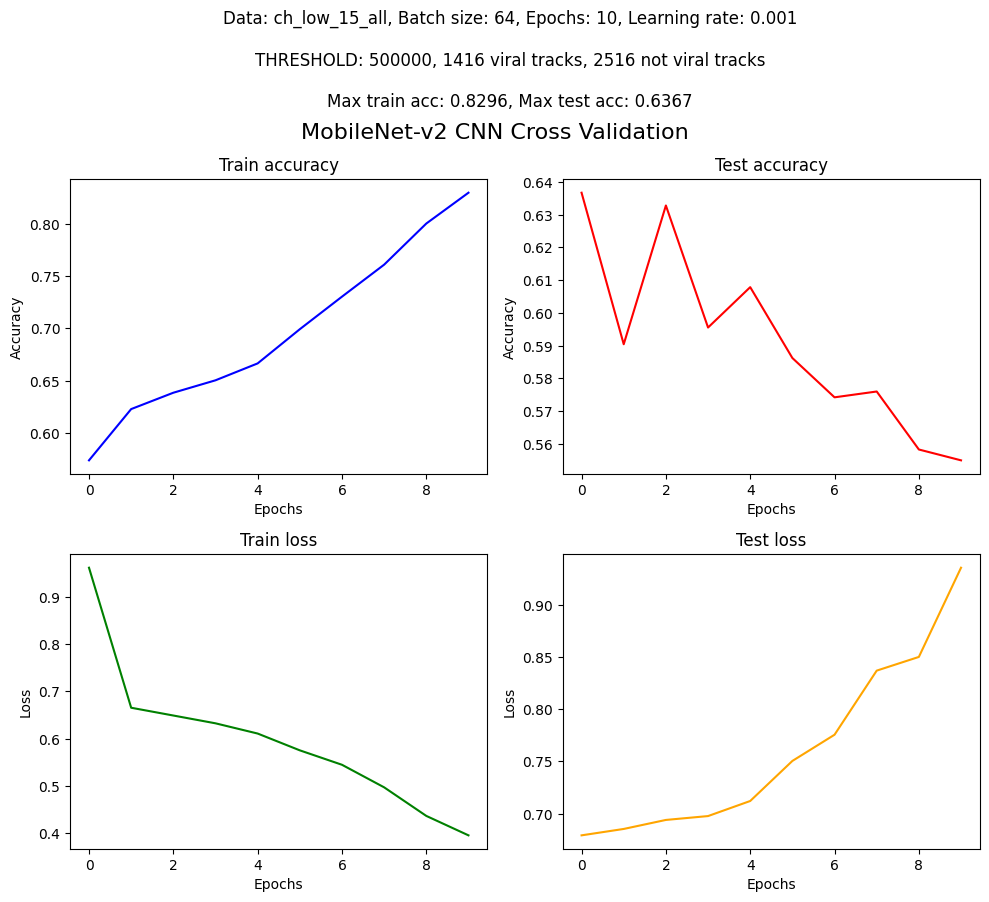

In [ ]:
fig = plt.figure(figsize=(10, 8))
# supertitle
fig.suptitle(f'{model_name} CNN Cross Validation', fontsize=16)
info = f"""Data: {dir_name}, Batch size: {BATCH}, Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE}\n
THRESHOLD: {HIGH_THRESHOLD}, {num_viral} viral tracks, {num_not_viral} not viral tracks\n
Max train acc: {max_train_acc:.4f}, Max test acc: {max_test_acc:.4f}"""
fig.text(0.515, 1, info, ha="center", fontsize=12)


sub1 = fig.add_subplot(221)
sub1.set_title("Train accuracy")
sub1.plot(average_history["train_acc"], color="blue", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

sub2 = fig.add_subplot(222)
sub2.set_title("Test accuracy")
sub2.plot(average_history["test_acc"], color="red", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

sub3 = fig.add_subplot(223)
sub3.set_title("Train loss")
sub3.plot(average_history["train_loss"], color="green", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")


sub4 = fig.add_subplot(224)
sub4.set_title("Test loss")
sub4.plot([l.item() for l in average_history["test_loss"]], color="orange", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.6 MB/s eta 0:00:00


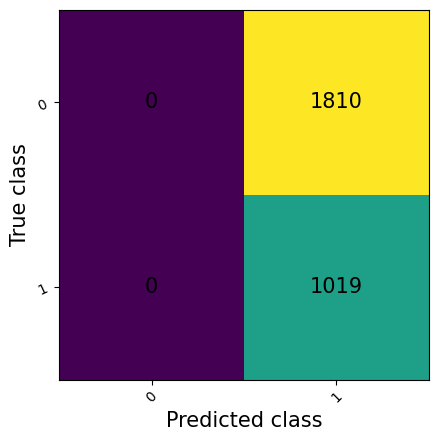

In [ ]:
!pip install torchmetrics
from torchmetrics.classification import BinaryConfusionMatrix

metric = BinaryConfusionMatrix().to(device)
model.eval()

with torch.no_grad():
  for i, (x, y) in enumerate(train_dl):
    # if i==2:
      # break
    (x, y) = (x.to(device), y.to(device))
    pred = model(x).to(device)
    metric.update(pred[:,1], y)

fig, ax = metric.plot()

